In [1]:
import os
import json
import argparse
from random import shuffle, seed
import string
# non-standard dependencies:
import h5py
import numpy as np
import torch
import torchvision.models as models
import skimage.io
from PIL import Image



/home/why/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def build_vocab(imgs):
    count_thr = 5

  
    counts = {}
    for img in imgs:
        for sent in img['sentences']:
            for w in sent['tokens']:
                counts[w] = counts.get(w, 0) + 1
    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)     # 按词频排序
    print('top words and their counts:')
    print('\n'.join(map(str,cw[:20])))      #打印前20个词频最高的词

  # 统计词频分布
    total_words = sum(counts.values())    #总单词数
    print('total words:', total_words)     
    bad_words = [w for w,n in counts.items() if n <= count_thr]   #统计词频小于5的单词
    vocab = [w for w,n in counts.items() if n > count_thr]      #用词频大于5的单词构建词典
    bad_count = sum(counts[w] for w in bad_words)                # 统计所有低频词出现的次数
    
    print('number of bad words: %d/%d = %.2f%%' % (len(bad_words), len(counts), len(bad_words)*100.0/len(counts)))
    print('number of words in vocab would be %d' % (len(vocab), ))
    print('number of UNKs: %d/%d = %.2f%%' % (bad_count, total_words, bad_count*100.0/total_words))

  # 统计句子长度分布
    sent_lengths = {}
    for img in imgs:
        for sent in img['sentences']:
            txt = sent['tokens']
            nw = len(txt)
            sent_lengths[nw] = sent_lengths.get(nw, 0) + 1
    max_len = max(sent_lengths.keys())
    print('max length sentence in raw data: ', max_len)
    print('sentence length distribution (count, number of words):')
    sum_len = sum(sent_lengths.values())
    for i in range(max_len+1):
        print('%2d: %10d   %f%%' % (i, sent_lengths.get(i,0), sent_lengths.get(i,0)*100.0/sum_len))
       

        
        
  # 添加未知词  （词频<=5的词归为未知词UNK ）
    if bad_count > 0:
        print('inserting the special UNK token')
        vocab.append('UNK') 
  
    for img in imgs:
        img['final_captions'] = []
        for sent in img['sentences']:
            txt = sent['tokens']
            caption = [w if counts.get(w,0) > count_thr else 'UNK' for w in txt]
            img['final_captions'].append(caption)

    return vocab

In [3]:
def encode_captions(imgs, wtoi):

    max_length = 20
    N = len(imgs)
    M = sum(len(img['final_captions']) for img in imgs) # 计算总的句子数

    label_arrays = []
    label_start_ix = np.zeros(N, dtype='uint32') # note: these will be one-indexed
    label_end_ix = np.zeros(N, dtype='uint32')
    label_length = np.zeros(M, dtype='uint32')
    caption_counter = 0
    counter = 1
    for i,img in enumerate(imgs):
        n = len(img['final_captions'])
        assert n > 0, 'error: some image has no captions'

        Li = np.zeros((n, max_length), dtype='uint32')
        for j,s in enumerate(img['final_captions']):
            label_length[caption_counter] = min(max_length, len(s)) # 判断当前图片caption 长度是否  大于最长句子
            caption_counter += 1
            for k,w in enumerate(s):
                if k < max_length:      #  超过长度的截断 
                    Li[j,k] = wtoi[w]  

        # note: word indices are 1-indexed, and captions are padded with zeros
        label_arrays.append(Li)
        label_start_ix[i] = counter    # 图像  第一个描述  标号
        label_end_ix[i] = counter + n - 1   # 图像结尾描述标号

        counter += n

    L = np.concatenate(label_arrays, axis=0) # 所有caption 拼接起来   （图像数 * 5， max_len）
    assert L.shape[0] == M, 'lengths don\'t match? that\'s weird'
    assert np.all(label_length > 0), 'error: some caption had no words?'

    print('encoded captions to array of size ', L.shape)
    return L, label_start_ix, label_end_ix, label_length



In [4]:
def main():
    
    ################################################
    
    imgs = json.load(open(input_json, 'r'))
    imgs = imgs['images']    

#     with open("/home/why/image-captioning-bottom-up-top-down/other_dataset/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json", 'r') as j:
#         word_map = json.load(j)

    with open("f30_top_1_topic_class.json", 'r') as j:
        image_topclass= json.load(j)

    with open("f30_top_1_topic_word.json", 'r') as j:
        image_topword= json.load(j)

  #############################################################################  
    
    seed(123) # make reproducible
    vocab = build_vocab(imgs)
    
    
    wtoi = {w:i+1 for i,w in enumerate(vocab)} # 词  -->  数字
    itow = {i+1:w for i,w in enumerate(vocab)} # 数字  -->  词
    
    L, label_start_ix, label_end_ix, label_length = encode_captions(imgs, wtoi)
    
    N = len(imgs)
    f_lb = h5py.File(output_h5+'_label.h5', "w")
    f_lb.create_dataset("labels", dtype='uint32', data=L)                         
    f_lb.create_dataset("label_start_ix", dtype='uint32', data=label_start_ix)
    f_lb.create_dataset("label_end_ix", dtype='uint32', data=label_end_ix)
    f_lb.create_dataset("label_length", dtype='uint32', data=label_length)
    f_lb.close()

    out = {}
    out['ix_to_word'] = itow # encode the (1-indexed) vocab
    out['images'] = []
    for i,img in enumerate(imgs):
        jimg = {}
        jimg['split'] = img['split']
        if 'filename' in img: jimg['file_path'] = os.path.join(img.get('filepath',''), img['filename']) # copy it over, might need
        if 'cocoid' in img: 
            jimg['id'] = img['cocoid'] # copy over & mantain an id, if present (e.g. coco ids, useful)
        elif 'imgid' in img:
            jimg['id'] = img['imgid']
        
        image_id = img['filename'].split('.')[0]

        top_class = image_topclass[str(image_id)]
        word = image_topword[str(image_id)]
        word = word.split(' ')
        enc_w = [wtoi.get(word, wtoi['UNK']) for word in word]
        jimg['topic_class'] = top_class
        jimg['topic_word'] = enc_w
        
        
        if images_root != '':
            with Image.open(os.path.join(images_root, img['filepath'], img['filename'])) as _img:
                jimg['width'], jimg['height'] = _img.size

        out['images'].append(jimg)

    json.dump(out, open(output_json, 'w'))
    print('wrote ', output_json)



In [5]:
images_root=''
input_json='/home/why/data/caption/dataset_flickr30k.json'
output_json ='/home/sdb1/why/self-critical/data/f30_data.json'
output_h5 ='/home/sdb1/why/self-critical/data/f30_data'

In [52]:
import json
output_json ='/home/sdb1/why/self-critical/len_16/f30_data.json'

In [53]:
data = json.load(open(output_json,'r'))

In [59]:
a = data['images']

In [70]:
for i in a:
    if i['id'] == 20:
        print(i['topic_class'])
        print(i['topic_word'])

23
[29, 276, 97, 30, 55, 123, 96, 85, 93, 159, 692, 834, 2710, 417, 1051, 157, 2039, 2266, 647, 525]


In [71]:
w = data['ix_to_word']

In [72]:
t = [29, 276, 97, 30, 55, 123, 96, 85, 93, 159, 692, 834, 2710, 417, 1051, 157, 2039, 2266, 647, 525]

In [73]:
for i in t:
    print(w[str(i)])

man
jacket
black
blue
wearing
coat
gray
hat
jeans
brown
sweatshirt
sweater
leather
pants
backpack
dark
scarf
hoodie
sunglasses
tan


In [6]:
main()

top words and their counts:
(265492, 'a')
(81628, 'in')
(61368, 'the')
(44545, 'on')
(43362, 'and')
(41564, 'man')
(40237, 'is')
(38092, 'of')
(35432, 'with')
(21582, 'woman')
(21100, 'two')
(19794, 'are')
(17302, 'to')
(17024, 'people')
(15934, 'at')
(15600, 'an')
(15373, 'wearing')
(14083, 'shirt')
(12971, 'white')
(12857, 'young')
total words: 1911068
number of bad words: 11460/18459 = 62.08%
number of words in vocab would be 6999
number of UNKs: 21558/1911068 = 1.13%
max length sentence in raw data:  78
sentence length distribution (count, number of words):
 0:          0   0.000000%
 1:          0   0.000000%
 2:         23   0.014832%
 3:        197   0.127039%
 4:        859   0.553943%
 5:       3169   2.043593%
 6:       7531   4.856516%
 7:      10698   6.898820%
 8:      12866   8.296898%
 9:      14791   9.538273%
10:      15393   9.926485%
11:      14443   9.313858%
12:      12844   8.282711%
13:      11401   7.352164%
14:       9996   6.446121%
15:       8000   5.158960%


In [1]:
sss = [0.000000,0.000000,0.014832,0.127039,0.553943,2.043593,4.856516,6.898820,8.296898,9.538273,9.926485,9.313858,8.282711,7.352164,
      6.446121,5.158960,4.241310,3.365577,2.752305,2.214484,1.727607,1.358741,1.063391,0.857677,0.705488,0.580383,0.454633,0.332753,0.272135,0.236022,0.184433]


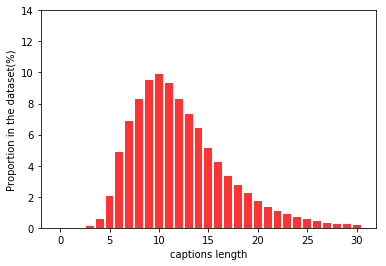

In [28]:
import matplotlib.pyplot as plt

from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']



label_list = [i for i in range(30)]
num_list1 = sss
x = range(len(num_list1))
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""
rects1 = plt.bar(x=x, height=num_list1, width=0.8, alpha=0.8, color='red')
#rects2 = plt.bar(left=[i + 0.4 for i in x], height=num_list2, width=0.4, color='green', label="二部门")
plt.ylim(0, 14)     # y轴取值范围
plt.ylabel('Proportion in the dataset(%)')
"""
设置x轴刻度显示值
参数一：中点坐标
参数二：显示值
"""
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('captions length')
#plt.title("sdsdsd")
#plt.legend()     # 设置题注
# 编辑文本
# for rect in rects1:
#     height = rect.get_height()
    #plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
    
plt.savefig('caption_length.png')
plt.show()

In [2]:
scoco = [0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.002270,
0.786521,16.438461,21.812289,21.492395,15.436299, 9.823807,5.712530,3.245310,1.860670,1.122304,0.699292,
0.446684,0.310166,0.212722,0.149651,0.107820,0.081554,
0.053181,0.041831,0.031454,0.025293,0.015727,0.011998,0.008431]

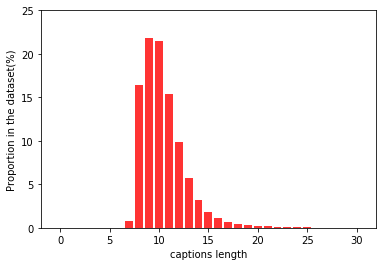

In [30]:
import matplotlib.pyplot as plt
import matplotlib


label_list = [i for i in range(30)]
num_list1 = scoco
x = range(len(num_list1))
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""
rects1 = plt.bar(x=x, height=num_list1, width=0.8, alpha=0.8, color='red')
#rects2 = plt.bar(left=[i + 0.4 for i in x], height=num_list2, width=0.4, color='green', label="二部门")
plt.ylim(0, 25)     # y轴取值范围
plt.ylabel('Proportion in the dataset(%)')
"""
设置x轴刻度显示值
参数一：中点坐标
参数二：显示值
"""
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('captions length')
#plt.title("sdsdsd")
#plt.legend()     # 设置题注
# 编辑文本
# for rect in rects1:
#     height = rect.get_height()
    #plt.text(rect.get_x() + rect.get_width() / 2, height+1, str(height), ha="center", va="bottom")
    
plt.savefig('coco_caption_length.png')
plt.show()

In [3]:
scoco = [0.000000,0.000000,0.000000,0.000000,0.000000,0.000162,0.002270,
0.786521,16.438461,21.812289,21.492395,15.436299, 9.823807,5.712530,3.245310,1.860670,1.122304,0.699292,
0.446684,0.310166,0.212722,0.149651,0.107820,0.081554,
0.053181,0.041831,0.031454,0.025293,0.015727,0.011998,0.008431]

In [4]:
sss = [0.000000,0.000000,0.014832,0.127039,0.553943,2.043593,4.856516,6.898820,8.296898,9.538273,9.926485,9.313858,8.282711,7.352164,
      6.446121,5.158960,4.241310,3.365577,2.752305,2.214484,1.727607,1.358741,1.063391,0.857677,0.705488,0.580383,0.454633,0.332753,0.272135,0.236022,0.184433]


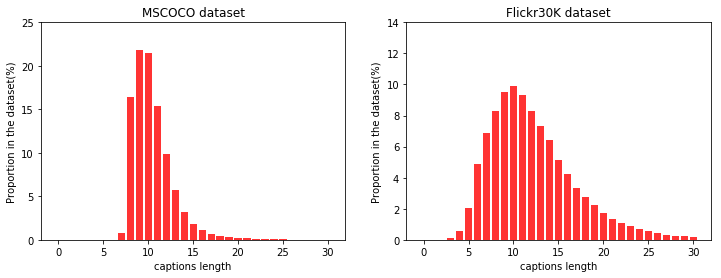

In [19]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize = (12,4))

plt.subplot(1,2,1)

label_list = [i for i in range(30)]
num_list1 = scoco
x = range(len(num_list1))
rects1 = plt.bar(x=x, height=num_list1, width=0.8, alpha=0.8, color='red')
plt.ylim(0, 25) 
plt.ylabel('Proportion in the dataset(%)')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('captions length')
plt.title("MSCOCO dataset")

plt.subplots_adjust(wspace = 0.2)

plt.subplot(1,2,2)
label_list = [i for i in range(30)]
num_list1 = sss
x = range(len(num_list1))
rects1 = plt.bar(x=x, height=num_list1, width=0.8, alpha=0.8, color='red')
plt.ylim(0, 14)
plt.ylabel('Proportion in the dataset(%)')
plt.xticks([0,5,10,15,20,25,30])
plt.xlabel('captions length')
plt.title("Flickr30K dataset")

plt.savefig('coco_caption_length.png')
plt.show()

In [2]:
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
aa = json.load(open(output_json,'r'))

NameError: name 'json' is not defined

In [77]:
iii = aa['images'][55]['file_path']

In [78]:
aa['images'][55]

{'split': 'restval',
 'file_path': 'val2014/COCO_val2014_000000191381.jpg',
 'id': 191381,
 'topic_class': 41,
 'topic_word': [432,
  219,
  163,
  46,
  438,
  454,
  7,
  482,
  544,
  123,
  489,
  480,
  497,
  98,
  120,
  218,
  194,
  457,
  733,
  527],
 'width': 640,
 'height': 480}

In [79]:
iii = images_root+'/'+iii

In [80]:
iii

'/home/sdb1/why/COCO/val2014/COCO_val2014_000000191381.jpg'

In [1]:
image = Image.open(iii)
plt.imshow(image)
plt.show

NameError: name 'Image' is not defined